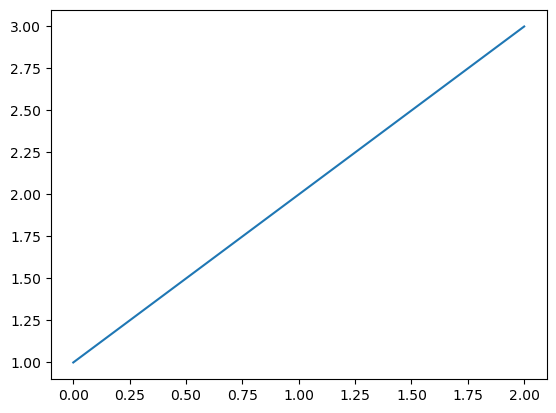

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot([1,2,3])

In [2]:
# pip install pyro-ppl

In [2]:
import os
import torch
import numpy as np
import scipy.stats
from torch.distributions import constraints
import pandas as pd

import pyro
import pyro.distributions as dist
from pyro import poutine
from pyro.infer.autoguide import AutoDelta,AutoNormal
from pyro.optim import Adam
from pyro.infer import SVI, TraceEnum_ELBO, Trace_ELBO, config_enumerate, infer_discrete

import random


In [4]:
pi = [1/2,1/3,1/6]
mu = [1.0,5.0,10.0]
sigma2 = [1.0,1.5,2.0]

In [5]:
n_samples = 10000
data = []

#first we generate n_samples samples from the distribution pi i.e. a sequece of the form {1,3,1,2,1,3,3,2,.....}
cluster_assignments = np.random.choice(3,n_samples,p=pi)


# for each of the indices in cluster_assignments we sample from the Normal(mu[idx],sigma2[idx]) distribution
for assignment in cluster_assignments:
    mean = mu[assignment]
    var = sigma2[assignment]
    sample = np.random.normal(mean,var)
    data.append(sample)

In [6]:
# for convenience we structure the data set as a pandas DataFrame
df = pd.DataFrame(data=data,columns=['data'])

In [7]:
df

,data
0,1.581406
1,1.285808
2,1.700077
3,3.683744
4,5.138233
...,...
9995,3.908401
9996,-0.653116
9997,10.987535
9998,-1.914829


In [8]:
# We need the data as a tensor
data = torch.tensor(data)

In [9]:
data.shape

torch.Size([10000])

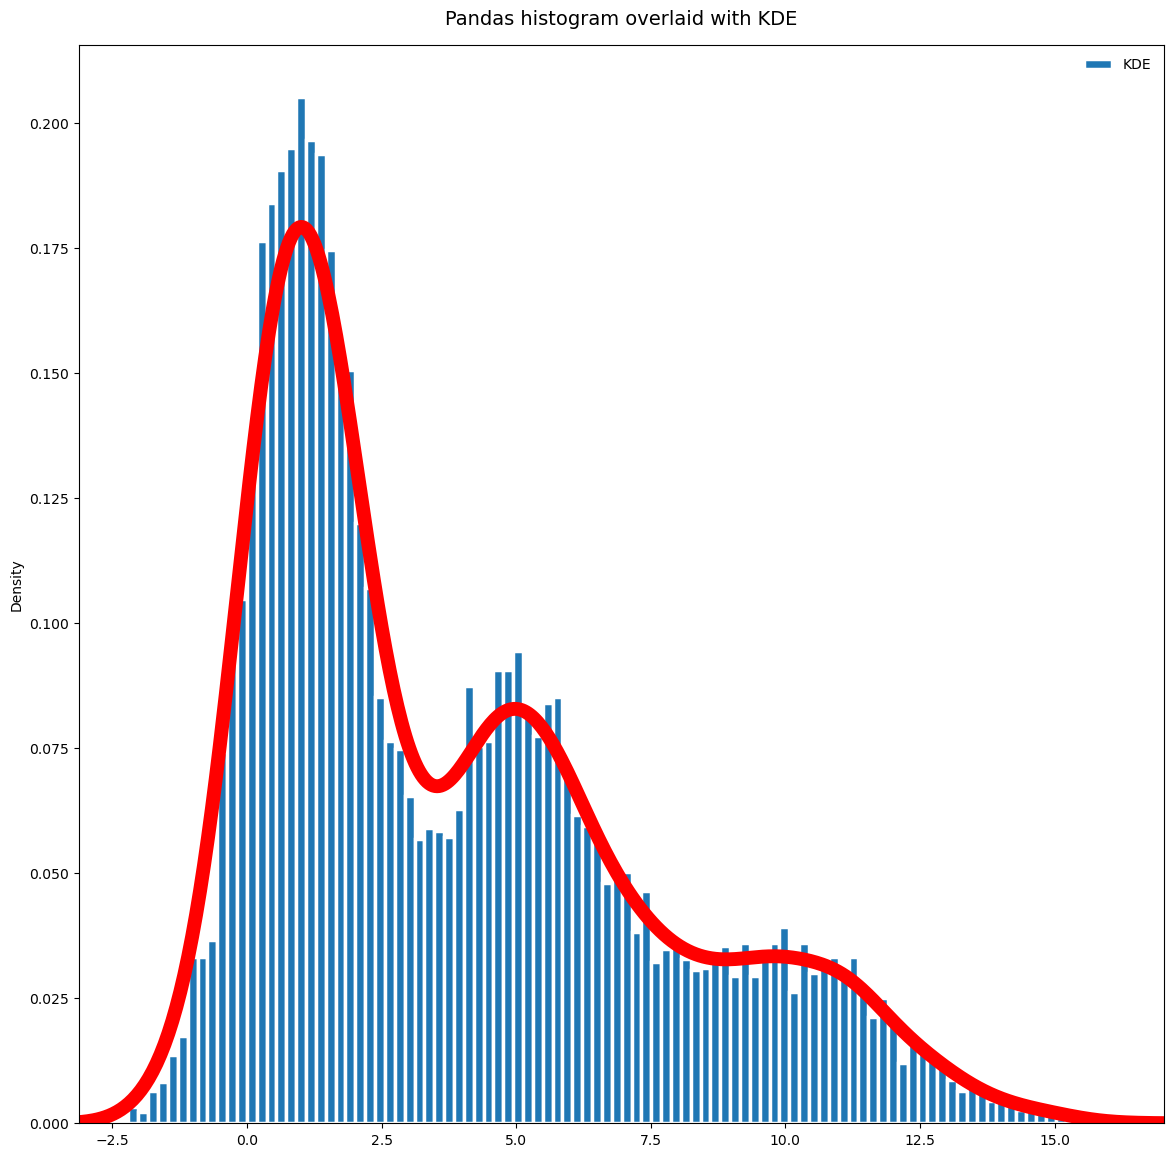

In [10]:
#this code displays the histogram of the data set with a smooth curve overlaid
import seaborn as sns

plt.rcParams["figure.figsize"] = (14,14)

ax = df['data'].plot.hist(bins=100, density=True, edgecolor='w', linewidth=2.5)

# Save default x-axis limits for final formatting because the pandas kde
# plot uses much wider limits which usually decreases readability
xlim = ax.get_xlim()

# Plot pandas KDE
df['data'].plot.density(color='r', linewidth = 10,alpha=1, ax=ax) # same as df['var'].plot.kde()

# Reset x-axis limits and edit legend and add title
ax.set_xlim(xlim)
ax.legend(labels=['KDE'], frameon=False)
ax.set_title('Pandas histogram overlaid with KDE', fontsize=14, pad=15)

plt.show()

In [11]:
# we first have to define the pyro model. We first specify the prior. There are three groups of parameters: the weights i.e.
# the distribution over {0,1,2}, the means for each of the tree Gaussians and their variances. These are all independent so
# the prior is a product of the distributions over each parameter
K=3

@config_enumerate
def model(data):
    samples = []
    # the distribution pi is sampled from a Dirichlet distribution. The Dirichlet is a distribution over the
    # probability simplex i.e. all vectors $x_1,x_2,...,x_n$ with x_i > 0 and summing up to 1
    # each of the parameters are stored in the pyro.param_store as items in a dict, as we can see they all have to be named.
    # In pyro distributions are basically characterized by their samples
    weights=pyro.sample('weights',dist.Dirichlet(0.5*torch.ones(K)))
    
    #the pyro.plate specifies an array of independent distributions. Here the distribution for each of the means is a
    #Gaussian with mean 0 and variance 10, the variances have a LogNormal distribution since the have to be > 0.
    # these distributions are stored in an array in the param_store named 'components'
    with pyro.plate('components',K):
        #the prior distriburion of the means
        locs = pyro.sample('locs',dist.Normal(0.,10.))
        # the prior distribution of the variances
        scales = pyro.sample('scales',dist.LogNormal(0.,2.))
        
    #here is the likelihood, for each data point an assignment to a Gaussian and then it is a sample from that Gaussian
    # first a sample from the distribution pi, which in turn is a sample from the Dirichlet distribution above.
    # then a sample from the corresponding Gaussian with mean and variance sampled from the appropriate priors
    with pyro.plate('data',len(data)):
        assignment = pyro.sample('assignment',dist.Categorical(weights))
        pyro.sample('obs',dist.Normal(locs[assignment],scales[assignment]),obs=data)
        

In [12]:
optim = pyro.optim.Adam({'lr':0.01,'betas':[0.8,0.99]})
elbo = TraceEnum_ELBO(max_plate_nesting=1)

In [13]:
#Here we initialize the values, the 'weights' = [1/3,1/3,1/3], the 'scales = variances' = [1,1,1]
# and the 'locs=means' = randomly chosen from the data with equal probability
def init_loc_fn(site):
    if site['name'] == 'weights':
        return torch.ones(K)/K
    if site['name'] == 'scales':
        return torch.ones(K)
    if site['name'] == 'locs':
        return data[torch.multinomial(torch.ones(len(data))/len(data),K)]
    raise ValueError(site['name'])
    

In [14]:
seed = 325

In [15]:
pyro.set_rng_seed(seed) #this initializes the random number generator
pyro.clear_param_store() #This clears out any previous values that might still be stored
    
guide = AutoDelta(poutine.block(model,expose=['weights','locs','scales']),init_loc_fn =  init_loc_fn )
#Here we define the Variational Distribution as a DElta function. The initial parameters are set
#by the init_loc_fn function

svi = SVI(model,guide,optim,loss=elbo)
#This is the object that takes care of all the inference and does stochastic variational inference
#to find the optimal parameters (i.e. maximizing the ElBO)


In [16]:
#Here we run the training loop, the svi object takes care of computing the Monte Carlo gradient
#and updating the parameters at each step
losses = []
for i in range(1000):
    loss = svi.step(data)
    losses.append(loss)
    if i % 10 == 0:
        print(loss)

31843.00390625
29606.376953125
28156.330078125
27245.095703125
26640.37109375
26215.404296875
25907.857421875
25681.666015625
25513.4140625
25387.56640625
25293.060546875
25221.849609375
25167.83984375
25126.826171875
25095.302734375
25070.865234375
25051.431640625
25035.806640625
25023.0234375
25012.375
25003.296875
24995.3671875
24988.3203125
24982.041015625
24976.43359375
24971.27734375
24966.478515625
24962.06640625
24958.0625
24954.23828125
24950.630859375
24947.333984375
24944.173828125
24941.208984375
24938.4375
24935.65625
24932.955078125
24930.455078125
24927.92578125
24925.45703125
24923.08984375
24920.576171875
24918.22265625
24915.615234375
24912.98828125
24910.533203125
24907.673828125
24904.837890625
24901.81640625
24898.685546875
24895.28125
24891.751953125
24888.095703125
24884.20703125
24880.134765625
24876.0390625
24871.939453125
24867.8828125
24864.00390625
24860.478515625
24857.455078125
24854.8515625
24852.912109375
24851.49609375
24850.486328125
24849.982421875
24

Text(0.5, 1.0, 'Convergence of SVI')

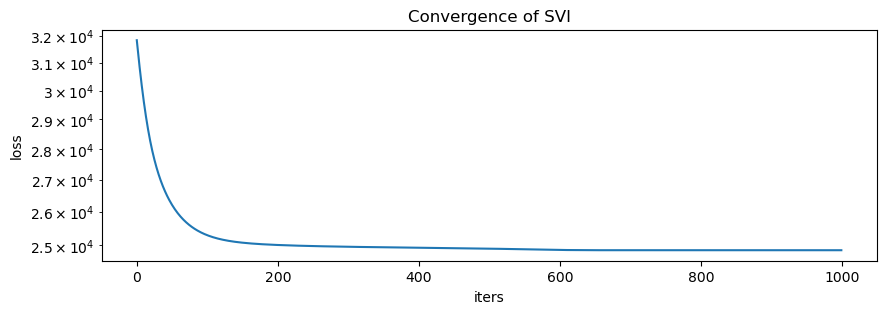

In [17]:
plt.figure(figsize=(10,3),dpi=100).set_facecolor('white')
plt.plot(losses)
plt.xlabel('iters')
plt.ylabel('loss')
plt.yscale('log')
plt.title('Convergence of SVI')


In [18]:
map_estimates = guide(data)
weights = map_estimates['weights']
locs = map_estimates['locs']
scales = map_estimates['scales']
print('weights ={}'.format(weights.data.numpy()))
print('locs={}'.format(locs.data.numpy()))
print('scales = {}'.format(scales.data.numpy()))

weights =[0.3174581  0.50891113 0.17363077]
locs=[4.982126  0.9934757 9.950868 ]
scales = [1.4953835  0.99755025 2.0022557 ]


In [19]:
pi = [1/2,1/3,1/6]
mu = [1.0,5.0,10.0]
sigma2 = [1.0,1.5,2.0]